In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
!pip install catboost
import lightgbm as lgb
import xgboost as xgb
from catboost import *
import catboost as ctb
from catboost import Pool
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score

from sklearn import preprocessing

import math
from six.moves import xrange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 3.2 MB/s eta 0:00:00


In [5]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
card = pd.read_csv(os.path.join(INPUT_DIR, "card.csv"))
user = pd.read_csv(os.path.join(INPUT_DIR, "user.csv"))
sub = pd.read_csv(os.path.join(INPUT_DIR, "sample_submit.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(card.shape)
display(card.head(3))

print(user.shape)
display(user.head(3))

print(sub.shape)
display(sub.head(3))

(471283, 12)


,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,0,1721,0,$2.623,OK,0,209237,Joliet,IL,60436.0,5541,Swipe Transaction
1,1,1629,3,$6.4,OK,0,2568,Edgerton,WI,53534.0,5814,Swipe Transaction
2,2,655,3,$123.5,OK,0,345310,Ridgefield,WA,98642.0,7538,Swipe Transaction


(457958, 11)


,index,user_id,card_id,amount,errors?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,471283,541,3,$113.278,OK,324189,Orlando,FL,32821.0,4814,Swipe Transaction
1,471284,655,1,$293.944,OK,81219,Ridgefield,WA,98642.0,7538,Chip Transaction
2,471285,492,0,$47.4,OK,274755,Arlington Heights,IL,60004.0,5719,Swipe Transaction


(416, 10)


,user_id,card_id,card_brand,card_type,expires,has_chip,cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,39,0,Visa,Debit,09/2021,YES,1,$17117,05/2007,2010
1,39,1,Amex,Credit,11/2024,YES,2,$5400,10/2015,2015
2,41,0,Discover,Credit,03/2022,YES,2,$14800,12/2010,2011


(97, 17)


,user_id,current_age,retirement_age,birth_year,birth_month,gender,address,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
0,39,57,64,1962,12,Female,442 Burns Boulevard,Mansfield,MA,2048,42.02,-71.21,$37407,$76274,$102611,698,2
1,41,39,66,1980,10,Female,3863 River Avenue,Lincoln,CA,95648,38.93,-121.25,$21829,$44506,$57994,849,3
2,47,40,67,1979,5,Female,8799 Elm Avenue,Mckinney,TX,75069,33.20,-96.65,$24684,$50329,$76759,625,4


(457958, 2)


,0,1
0,471283,0
1,471284,1
2,471285,0


In [6]:
print(f"number of train miss values : {train.isnull().sum().sum()}")
print(f"number of test miss values : {test.isnull().sum().sum()}")
print(f"number of card miss values : {card.isnull().sum().sum()}")
print(f"number of user miss values : {user.isnull().sum().sum()}")

number of train miss values : 149908
number of test miss values : 147412
number of card miss values : 0
number of user miss values : 0


In [7]:
train.isnull().sum()

index                 0
user_id               0
card_id               0
amount                0
errors?               0
is_fraud?             0
merchant_id           0
merchant_city         0
merchant_state    70688
zip               79220
mcc                   0
use_chip              0
dtype: int64

0    438652
1     32631
Name: is_fraud?, dtype: int64


<Axes: >

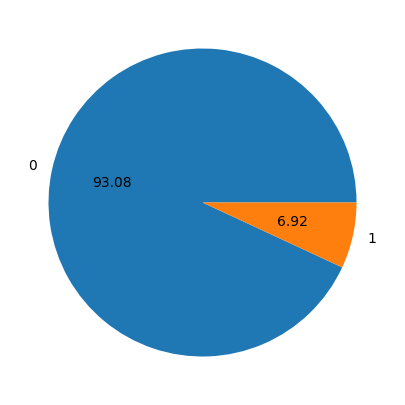

In [8]:
print(train["is_fraud?"].value_counts())

fig, ax = plt.subplots(figsize=[8, 5])
train.groupby("is_fraud?").size().plot(kind="pie", autopct="%.2f", ax=ax)

In [9]:
print(f"number of train user id {train.user_id.nunique()}")
print(f"number of test user id {test.user_id.nunique()}")

number of train user id 97
number of test user id 97


In [10]:
train["amount"] = train["amount"].astype(str).str.extract("(\d+)").astype("float32")
test["amount"] = test["amount"].astype(str).str.extract("(\d+)").astype("float32")

In [11]:
train = train.fillna("NAN")
test = test.fillna("NAN")

train_city_c = train["merchant_city"].value_counts().to_dict()
test_city_c = test["merchant_city"].value_counts().to_dict()
train_state_c = train["merchant_state"].value_counts().to_dict()
test_state_c = test["merchant_state"].value_counts().to_dict()

train["city_c"] = train["merchant_city"].map(lambda x: train_city_c[x]).values
test["city_c"] = test["merchant_city"].map(lambda x: test_city_c[x]).values
train["state_c"] = train["merchant_state"].map(lambda x: train_state_c[x]).values
test["state_c"] = test["merchant_state"].map(lambda x: test_state_c[x]).values

train.loc[train["city_c"]<20, "merchant_city"] = "small_city"
test.loc[test["city_c"]<20, "merchant_city"] = "small_city"
train.loc[train["state_c"]<20, "merchant_state"] = "small_state"
test.loc[test["state_c"]<20, "merchant_state"] = "small_state"

In [12]:
concat_data = pd.concat([train,test],axis=0)

concat_data = concat_data.merge(card, how="left", on=["user_id", "card_id"]).merge(user, how="left", on="user_id")

In [13]:
for col in ["errors?", "merchant_city", "merchant_state", "use_chip", "card_brand", "card_type", "has_chip", "gender", "city", "state"]:
  print(col)
  le = preprocessing.LabelEncoder()
  le.fit(concat_data[col])
  concat_data[col] = le.transform(concat_data[col])

errors?
merchant_city
merchant_state
use_chip
card_brand
card_type
has_chip
gender
city
state


In [14]:
concat_data["credit_limit"] = concat_data["credit_limit"].astype(str).str.extract("(\d+)").astype("float32")
concat_data["per_capita_income_zipcode"] = concat_data["per_capita_income_zipcode"].astype(str).str.extract("(\d+)").astype("float32")
concat_data["yearly_income_person"] = concat_data["yearly_income_person"].astype(str).str.extract("(\d+)").astype("float32")
concat_data["total_debt"] = concat_data["total_debt"].astype(str).str.extract("(\d+)").astype("float32")

In [15]:
concat_data["income_rate"] = concat_data["yearly_income_person"] / concat_data["per_capita_income_zipcode"]

In [16]:
numerical_features = ["amount", "cards_issued", "credit_limit", "current_age", "retirement_age", "birth_year", "latitude", "longitude",
                      "per_capita_income_zipcode", "yearly_income_person", "total_debt", "fico_score", "num_credit_cards", "income_rate"]
categorical_features = ["user_id", "card_id", "errors?", "merchant_id", "merchant_city", "merchant_state", "mcc", "use_chip",
                        "card_brand", "card_type", "has_chip", "gender", "city", "state",
                        "birth_month",
                        ]
target = "is_fraud?"

In [17]:
train_df = concat_data.iloc[:train.shape[0],:]
train_df = train_df.reset_index(drop=True)
test_df = concat_data.iloc[train.shape[0]:,:]
test_df = test_df.reset_index(drop=True)

In [18]:
corr_list = [target] + numerical_features
train_df[corr_list].corr()

,is_fraud?,amount,cards_issued,credit_limit,current_age,retirement_age,birth_year,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards,income_rate
is_fraud?,1.000000,0.149597,-0.007397,-0.025715,-0.012937,-0.017675,0.013430,0.011108,0.002455,-0.019102,-0.014999,-0.008619,-0.007951,-0.025561,0.004804
amount,0.149597,1.000000,-0.037866,0.084524,0.023139,-0.030107,-0.023042,-0.002821,-0.041324,0.154798,0.142497,0.007252,-0.035836,0.019420,0.037123
cards_issued,-0.007397,-0.037866,1.000000,-0.064020,-0.044524,-0.018097,0.043976,0.060634,-0.023949,-0.005225,0.010190,-0.047948,-0.021271,-0.023791,0.039431
credit_limit,-0.025715,0.084524,-0.064020,1.000000,-0.080352,0.006515,0.080956,0.092856,-0.073889,0.440021,0.408160,0.166334,-0.019523,0.030186,0.148308
current_age,-0.012937,0.023139,-0.044524,-0.080352,1.000000,0.019487,-0.999726,-0.124155,0.031799,-0.008372,-0.218768,-0.587462,-0.097298,0.619875,-0.601967
retirement_age,-0.017675,-0.030107,-0.018097,0.006515,0.019487,1.000000,-0.021244,0.061564,0.079153,-0.119159,-0.112547,-0.063628,0.406355,0.043890,-0.048149
birth_year,0.013430,-0.023042,0.043976,0.080956,-0.999726,-0.021244,1.000000,0.124970,-0.029487,0.005640,0.215684,0.586076,0.095567,-0.620038,0.599006
latitude,0.011108,-0.002821,0.060634,0.092856,-0.124155,0.061564,0.124970,1.000000,0.038502,0.078695,0.094596,0.132448,0.196359,-0.070248,0.066384
longitude,0.002455,-0.041324,-0.023949,-0.073889,0.031799,0.079153,-0.029487,0.038502,1.000000,-0.228946,-0.143185,-0.120019,0.129480,0.233339,0.008794
per_capita_income_zipcode,-0.019102,0.154798,-0.005225,0.440021,-0.008372,-0.119159,0.005640,0.078695,-0.228946,1.000000,0.913716,0.304466,-0.163083,0.096486,0.253331


In [19]:
class CFG:
  debug=False
  ver=16
  model="catboost"
  n_folds=5
  trn_fold=[0, 1, 2, 3, 4]
  seed=42
  target= target
  boosting_type="gbdt"
  early_stopping_round=50
  verbose=200

In [20]:
skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for fold, (train_index, valid_index) in enumerate(skf.split(train_df, train_df[CFG.target])):
    train_df.loc[valid_index, "fold"] = fold
train_df['fold'] = train_df['fold'].astype(int)
display(train_df.groupby('fold').size())

fold
0    94257
1    94257
2    94257
3    94256
4    94256
dtype: int64

In [21]:
if CFG.debug:
    display(train_df.groupby('fold').size())
    train_df = train_df.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train_df.groupby('fold').size())

In [22]:
class FocalLossObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # approxes, targets, weights are indexed containers of floats
        # (containers with only __len__ and __getitem__ defined).
        # weights parameter can be None.
        # Returns list of pairs (der1, der2)
        gamma = 2.
        # alpha = 1.
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        exponents = []
        for index in xrange(len(approxes)):
            exponents.append(math.exp(approxes[index]))

        result = []
        for index in xrange(len(targets)):
            p = exponents[index] / (1 + exponents[index])

            if targets[index] > 0.0:
                der1 = -((1-p)**(gamma-1))*(gamma * math.log(p) * p + p - 1)/p
                der2 = gamma*((1-p)**gamma)*((gamma*p-1)*math.log(p)+2*(p-1))
            else:
                der1 = (p**(gamma-1)) * (gamma * math.log(1 - p) - p)/(1 - p)
                der2 = p**(gamma-2)*((p*(2*gamma*(p-1)-p))/(p-1)**2 + (gamma-1)*gamma*math.log(1 - p))

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))

        return result

In [23]:
params = {
        'loss_function' : FocalLossObjective(),
        'eval_metric' : 'Logloss',
        "n_estimators":10000,
        "learning_rate":0.05,
        'depth': 4,
        "random_state":CFG.seed,
        'colsample_bylevel': 0.50,
        'subsample': 0.80,
        'l2_leaf_reg': 3,
    }

orig_features = numerical_features + categorical_features
oof_df = pd.DataFrame()
test_preds = np.zeros(len(test_df))

for fold in range(CFG.n_folds):
  if fold in CFG.trn_fold:
    print("="*15,f" FOLD : {fold} ","="*15)
    train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)

    train_X = train_folds[orig_features]
    valid_X = valid_folds[orig_features]
    test_X = test_df[orig_features]
    train_labels = train_folds[CFG.target].values
    valid_labels = valid_folds[CFG.target].values

    train_pool = Pool(train_X,
                     label=train_labels,
                    cat_features=categorical_features)
    valid_pool = Pool(valid_X,
                    label=valid_labels,
                    cat_features=categorical_features)

    model = ctb.CatBoostClassifier(**params)
    model.fit(train_pool,
              eval_set=[valid_pool],
              early_stopping_rounds=CFG.early_stopping_round,
              verbose=CFG.verbose,
              use_best_model=True)

    valid_folds["pred"] = model.predict_proba(valid_pool)[:, 1]
    test_preds += model.predict_proba(Pool(test_X,cat_features=categorical_features))[:, 1]
    oof_df = pd.concat([oof_df, valid_folds])

    validy_pred = np.where(valid_folds["pred"]>0.5, 1, 0)
    scoref1 =  f1_score(valid_labels, validy_pred)
    scoreacc = accuracy_score(valid_labels, validy_pred)
    print(f"F1 Score : {scoref1}")

===============  FOLD : 0  ===============
0:	learn: 0.6870890	test: 0.6870971	best: 0.6870971 (0)	total: 1.91s	remaining: 5h 19m 3s
200:	learn: 0.3091566	test: 0.3036930	best: 0.3036930 (200)	total: 2m 48s	remaining: 2h 16m 46s
400:	learn: 0.2708267	test: 0.2615651	best: 0.2615651 (400)	total: 5m 40s	remaining: 2h 15m 53s
600:	learn: 0.2625983	test: 0.2527334	best: 0.2527334 (600)	total: 8m 39s	remaining: 2h 15m 26s
800:	learn: 0.2593742	test: 0.2492483	best: 0.2492483 (800)	total: 11m 36s	remaining: 2h 13m 22s
1000:	learn: 0.2573250	test: 0.2471481	best: 0.2471456 (999)	total: 14m 38s	remaining: 2h 11m 38s
1200:	learn: 0.2559243	test: 0.2457193	best: 0.2457178 (1199)	total: 17m 36s	remaining: 2h 9m 2s
1400:	learn: 0.2546971	test: 0.2442002	best: 0.2441983 (1395)	total: 20m 38s	remaining: 2h 6m 44s
1600:	learn: 0.2537516	test: 0.2432838	best: 0.2432838 (1600)	total: 23m 44s	remaining: 2h 4m 32s
1800:	learn: 0.2529282	test: 0.2425610	best: 0.2425610 (1800)	total: 26m 47s	remaining: 2h 

KeyboardInterrupt: ignored

In [24]:
f1score =  f1_score(oof_df[CFG.target], np.where(oof_df["pred"]>0.5,1,0))
print(f'CV F1 Score: {f1score}')

CV F1 Score: 0.6359677629013389


In [25]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.15, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(oof_df[CFG.target], (oof_df["pred"]>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(oof_df[CFG.target], (oof_df["pred"]>best_thresh).astype(int))))

F1 score at threshold 0.15 is 0.22133153369912853
F1 score at threshold 0.16 is 0.24588813078875374
F1 score at threshold 0.17 is 0.27114317752596795
F1 score at threshold 0.18 is 0.29719809929542845
F1 score at threshold 0.19 is 0.3234731873488136
F1 score at threshold 0.2 is 0.35111741894215004
F1 score at threshold 0.21 is 0.3790234842906909
F1 score at threshold 0.22 is 0.4073293764973574
F1 score at threshold 0.23 is 0.43590855910925314
F1 score at threshold 0.24 is 0.46240345297592006
F1 score at threshold 0.25 is 0.48721983713504347
F1 score at threshold 0.26 is 0.5107722417026828
F1 score at threshold 0.27 is 0.5338671773000261
F1 score at threshold 0.28 is 0.5567361445337086
F1 score at threshold 0.29 is 0.5770143341765203
F1 score at threshold 0.3 is 0.5966619729975979
F1 score at threshold 0.31 is 0.6118816609146752
F1 score at threshold 0.32 is 0.6248811195145147
F1 score at threshold 0.33 is 0.6368878115365606
F1 score at threshold 0.34 is 0.6474620094153231
F1 score at th

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0


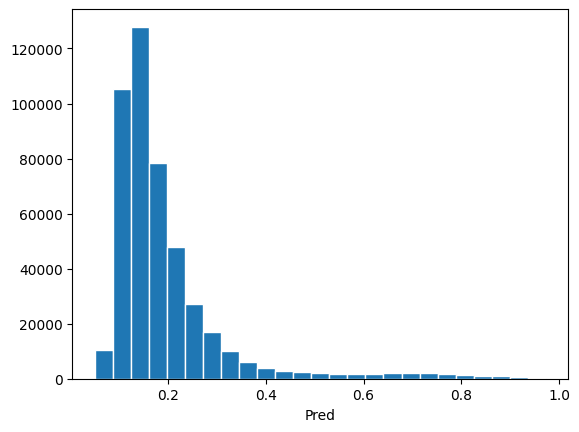

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


In [26]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = test_preds / 3
submit[1] = (pred>best_thresh).astype(int)

submit.to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
display(submit.head())

plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit)

In [27]:
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')

if not os.path.exists(OOF_DIR):
    os.makedirs(OOF_DIR)

oof_df.to_csv(os.path.join(OOF_DIR, f'oof_{CFG.model}_ver{CFG.ver}.csv'))

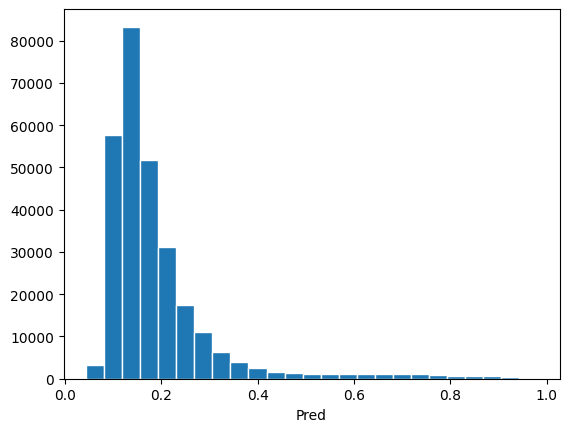

In [28]:
plt.hist(oof_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()